# IAU projekt

> Rovnakým podieľom práce vypracovali: <br>
> Roman Bitarovský, Emma Macháčová

# Fáza 2 Predspracovanie údajov <a name="faza2"></a>
## 2.1 Integrácia a čistenie dát (5b) <a name=""></a>
Transformujte dáta na vhodný formát pre strojové učenie t.j. jedno pozorovanie musí byť opísané jedným riadkom a každý atribút musí byť v numerickom formáte. 
* Pri riešení chýbajúcich hodnôt (missing values) vyskúšajte rôzne stratégie ako napr.
    * odstránenie pozorovaní s chýbajúcimi údajmi
    * nahradenie chýbajúcej hodnoty mediánom, priemerom, pomerom (ku korelovanému atribútu), alebo pomocou lineárnej regresie resp. kNN
* Podobne postupujte aj pri riešení vychýlených hodnôt (outlier detection):
    * odstránenie vychýlených (odľahlých) pozorovaní
    * nahradenie vychýlenej hodnoty hraničnými hodnotami rozdelenia (5% resp. 95%)

In [1]:
pause

In [2]:
# čo sa myslí tou transformáciou dát na jeden riadok ? 

# Data init

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import scipy.stats as stats
import statsmodels.api as sm
import statsmodels.stats.api as sms
import statsmodels.stats as sm_stats
from scipy.stats import mannwhitneyu
from scipy.stats import f_oneway

import datetime
import re
import category_encoders as ce
from sklearn.impute import SimpleImputer, KNNImputer
from numpy import percentile

from sklearn.preprocessing import PowerTransformer, QuantileTransformer

from sklearn.feature_selection import VarianceThreshold, SelectKBest, SelectPercentile, SelectFromModel
from sklearn.feature_selection import mutual_info_regression, chi2, f_regression, f_classif
from sklearn.ensemble import RandomForestClassifier

from sklearn.preprocessing import StandardScaler, MinMaxScaler

from sklearn.base import TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split

In [4]:
labor_measurements = pd.read_csv('../081/measurements.csv', sep='\t')
labor_stations = pd.read_csv('../081/stations.csv', sep='\t')

In [5]:
labor_stations["QoS"].replace({"acceptable": "accep", "maitennce": "maintenance"}, inplace=True)
labor_stations['revision'] = pd.to_datetime(labor_stations['revision'], utc=False)

labor_measurements.replace('', np.nan, inplace=True)
labor_stations.replace('', np.nan, inplace=True)

labor_measurements = labor_measurements.drop_duplicates()
labor_stations = labor_stations.drop_duplicates()

# merge preprocesing
labor_stations = labor_stations.drop(columns=['revision', 'code', 'QoS'])
labor_stations = labor_stations.drop_duplicates()

# Table merge
df = pd.merge(labor_measurements, labor_stations, how='inner', left_on=['latitude', 'longitude'], right_on=['latitude', 'longitude'])

df = df.drop(columns=['latitude', 'longitude'])
df = df[['location', 'warning', 'TEMP', 'PRES', 'PM2.5', 'NOx', 'PM10', 'C2H3NO5', 'CH4', 'Pb', 'NH3', 'SO2', 'O3', 'CO', 'PAHs', 'H2CO', 'CFCs']]

df.head()

,location,warning,TEMP,PRES,PM2.5,NOx,PM10,C2H3NO5,CH4,Pb,NH3,SO2,O3,CO,PAHs,H2CO,CFCs
0,America/Los_Angeles,0.0,20.05101,1139.12673,8.47714,9.21522,9.38738,1.51791,7.84989,59.51096,10.43604,5.81201,7.77502,9.69678,8.62090,47.64810,74.87342
1,America/Los_Angeles,1.0,21.55701,1115.19699,7.36880,9.66741,8.19826,0.64236,8.48027,54.03980,9.62838,7.97135,9.72566,5.83821,8.28391,64.99154,63.42154
2,America/Los_Angeles,1.0,3.06998,1086.02547,9.81855,9.66138,6.16989,0.23616,8.49506,47.32216,6.38848,6.14333,9.73098,7.37730,5.98279,43.12537,71.61779
3,America/Los_Angeles,1.0,10.04558,1168.02340,8.76470,10.27526,7.10130,0.17080,7.35744,48.49527,8.11869,6.74522,9.63330,4.89810,8.76285,43.67037,64.64020
4,America/Los_Angeles,1.0,24.88676,1061.95581,6.76710,9.95663,8.35517,0.75765,6.98671,52.91472,8.87397,9.24788,8.40595,10.82485,7.88543,40.39068,70.46390


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 11939 entries, 0 to 11938
Data columns (total 17 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   location  11939 non-null  object 
 1   warning   11891 non-null  float64
 2   TEMP      11891 non-null  float64
 3   PRES      11939 non-null  float64
 4   PM2.5     11891 non-null  float64
 5   NOx       11891 non-null  float64
 6   PM10      11891 non-null  float64
 7   C2H3NO5   11891 non-null  float64
 8   CH4       11891 non-null  float64
 9   Pb        11891 non-null  float64
 10  NH3       11891 non-null  float64
 11  SO2       11891 non-null  float64
 12  O3        11891 non-null  float64
 13  CO        11891 non-null  float64
 14  PAHs      11891 non-null  float64
 15  H2CO      11891 non-null  float64
 16  CFCs      11891 non-null  float64
dtypes: float64(16), object(1)
memory usage: 1.6+ MB


In [7]:
df_not_changed = df.copy()

## Replacing NaNs

In [8]:
def replaceNaN(df_original, strategy):
    df = df_original.copy()

    na_cols = df.columns[df.isnull().any()].tolist()
    
    if strategy == 'kNN':
        imp_strategy = KNNImputer(n_neighbors=5, weights='uniform', metric='nan_euclidean')

    elif strategy == 'mean' or strategy == 'median':    
        imp_strategy = SimpleImputer(missing_values=np.nan, strategy=strategy)
        
    elif strategy == 'drop_na':
        df = df.dropna()
        
    if strategy != 'drop_na':
        for col in na_cols:
            df[col] = imp_strategy.fit_transform(df[[col]])
        
    print(df.isnull().sum())
    
    fig, ax = plt.subplots(figsize=(16,8))
    corr_diff = df.corr() - df_original.corr()
    sns.heatmap(corr_diff[abs(corr_diff) > 0.000099], ax=ax, annot=True, fmt=".4f")
    
    return df

In [9]:
# prekodovanie textu locacie n číslo 
ce_ordinal = ce.OrdinalEncoder(cols=['location'])
df_ml = ce_ordinal.fit_transform(df)
df_ml

,location,warning,TEMP,PRES,PM2.5,NOx,PM10,C2H3NO5,CH4,Pb,NH3,SO2,O3,CO,PAHs,H2CO,CFCs
0,1,0.0,20.05101,1139.12673,8.47714,9.21522,9.38738,1.51791,7.84989,59.51096,10.43604,5.81201,7.77502,9.69678,8.62090,47.64810,74.87342
1,1,1.0,21.55701,1115.19699,7.36880,9.66741,8.19826,0.64236,8.48027,54.03980,9.62838,7.97135,9.72566,5.83821,8.28391,64.99154,63.42154
2,1,1.0,3.06998,1086.02547,9.81855,9.66138,6.16989,0.23616,8.49506,47.32216,6.38848,6.14333,9.73098,7.37730,5.98279,43.12537,71.61779
3,1,1.0,10.04558,1168.02340,8.76470,10.27526,7.10130,0.17080,7.35744,48.49527,8.11869,6.74522,9.63330,4.89810,8.76285,43.67037,64.64020
4,1,1.0,24.88676,1061.95581,6.76710,9.95663,8.35517,0.75765,6.98671,52.91472,8.87397,9.24788,8.40595,10.82485,7.88543,40.39068,70.46390
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11934,10,1.0,-4.79197,1130.15144,10.03862,7.85019,2.61045,0.16818,7.93426,42.37355,6.51674,7.03170,4.37153,9.76505,7.85202,32.10196,81.64000
11935,10,0.0,7.30387,1191.87826,9.53663,9.61895,8.89174,0.94656,7.79162,39.72329,6.95733,10.58370,7.47375,12.15236,8.80525,73.44011,63.83947
11936,10,1.0,16.43794,1080.62899,8.98586,8.92907,9.21569,1.45297,8.30146,54.14633,7.86831,7.67169,12.78567,7.00978,8.29119,60.99687,77.04895
11937,10,0.0,6.07748,1078.80233,11.18488,6.87410,7.21010,0.31668,8.18607,NaN,7.83408,9.00897,8.16025,11.34004,8.39922,53.89033,87.39587


### Drop nans

location    0
warning     0
TEMP        0
PRES        0
PM2.5       0
NOx         0
PM10        0
C2H3NO5     0
CH4         0
Pb          0
NH3         0
SO2         0
O3          0
CO          0
PAHs        0
H2CO        0
CFCs        0
dtype: int64


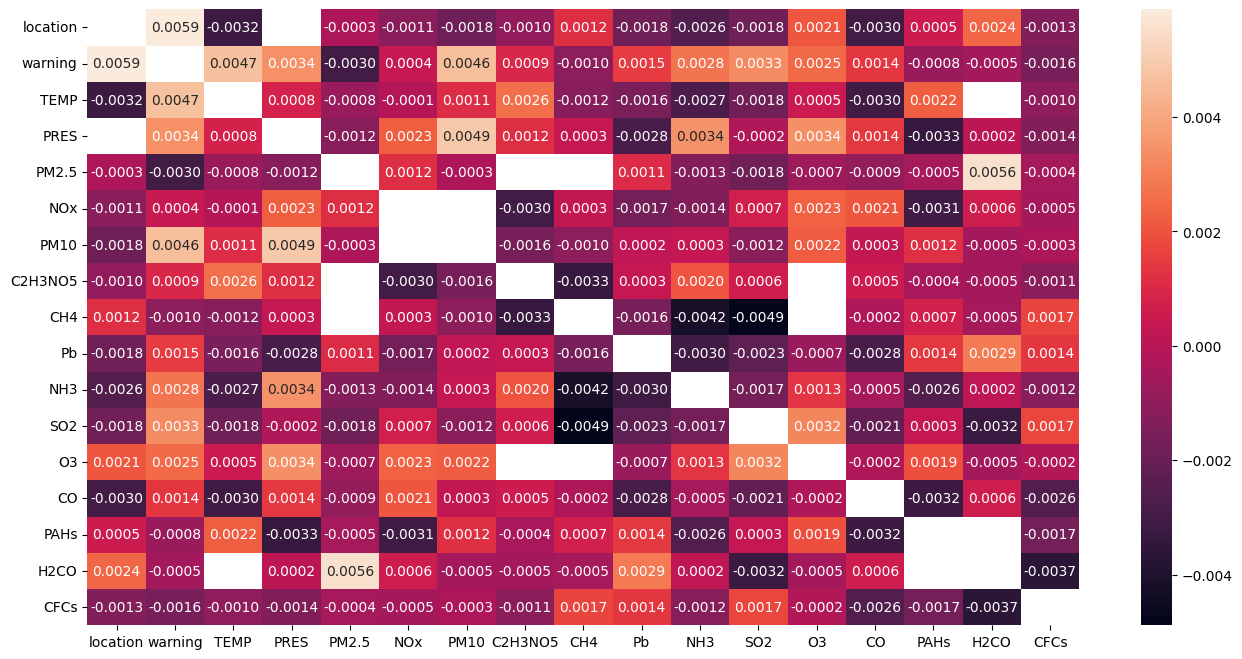

In [10]:
df_ml_dropedNa = replaceNaN(df_ml, 'drop_na')

### Mean

location    0
warning     0
TEMP        0
PRES        0
PM2.5       0
NOx         0
PM10        0
C2H3NO5     0
CH4         0
Pb          0
NH3         0
SO2         0
O3          0
CO          0
PAHs        0
H2CO        0
CFCs        0
dtype: int64


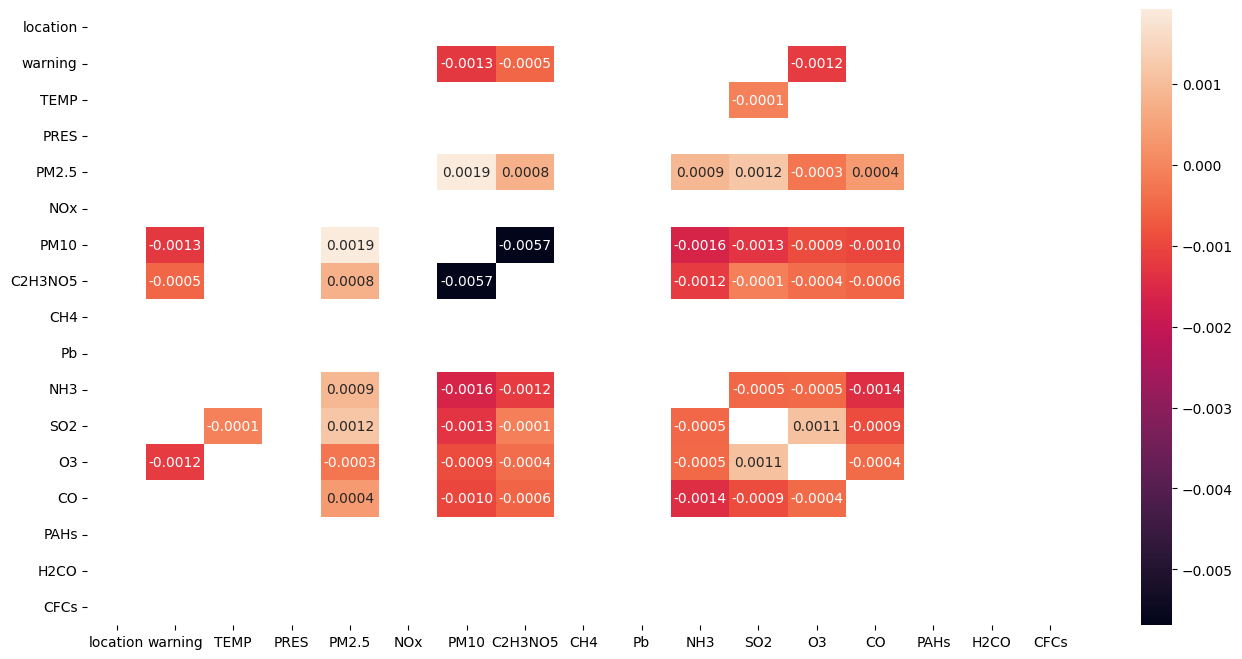

In [11]:
df_ml_na_mean = replaceNaN(df_ml, 'mean')

### Median

location    0
warning     0
TEMP        0
PRES        0
PM2.5       0
NOx         0
PM10        0
C2H3NO5     0
CH4         0
Pb          0
NH3         0
SO2         0
O3          0
CO          0
PAHs        0
H2CO        0
CFCs        0
dtype: int64


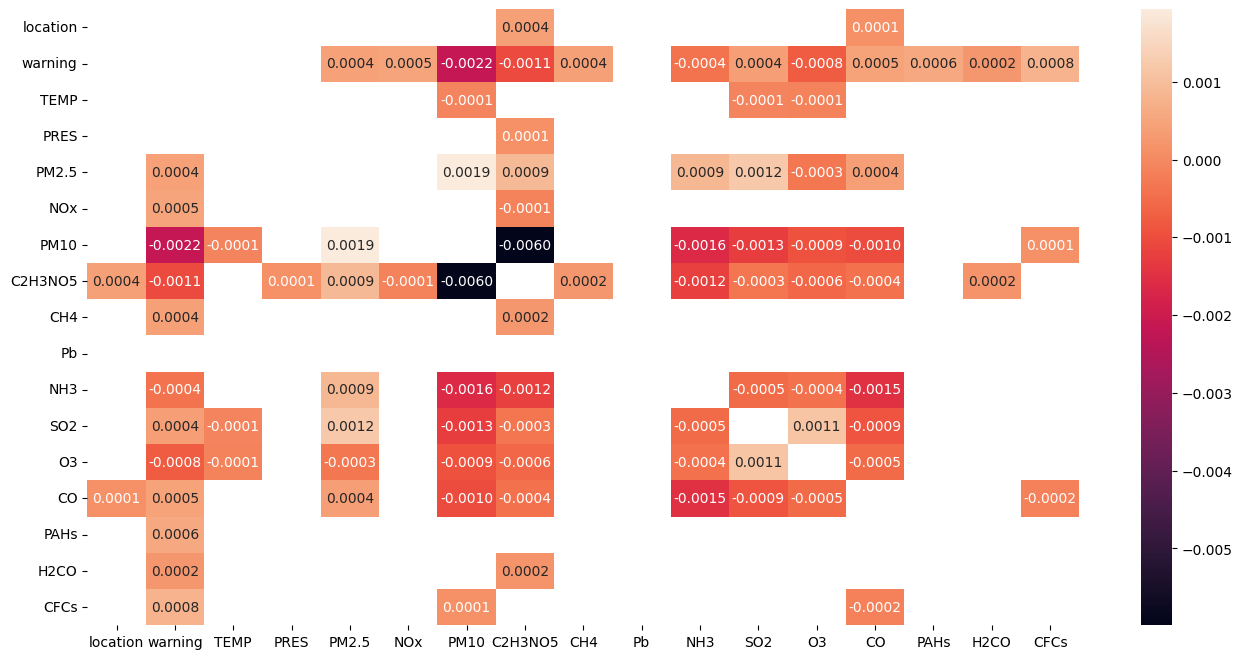

In [12]:
df_ml_na_median = replaceNaN(df_ml, 'median')

### kNN

location    0
warning     0
TEMP        0
PRES        0
PM2.5       0
NOx         0
PM10        0
C2H3NO5     0
CH4         0
Pb          0
NH3         0
SO2         0
O3          0
CO          0
PAHs        0
H2CO        0
CFCs        0
dtype: int64


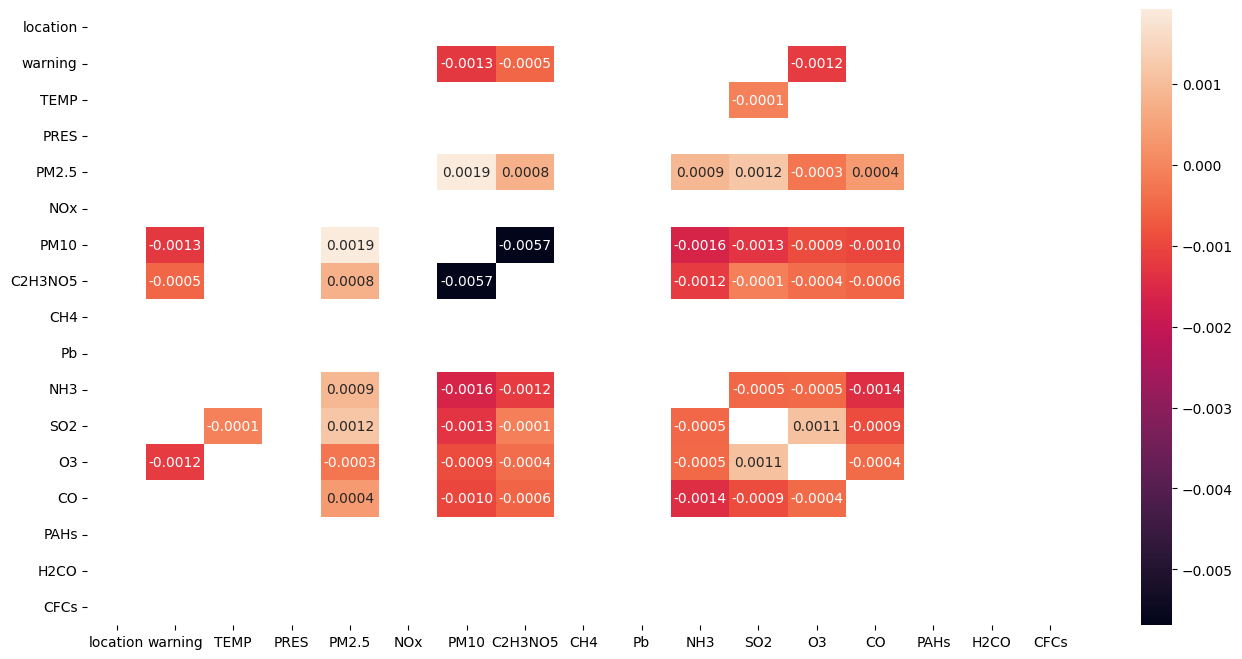

In [13]:
df_ml_na_knn = replaceNaN(df_ml, 'kNN')

## Deleting outliers vlaues

location       AxesSubplot(0.125,0.786098;0.227941x0.0939024)
warning     AxesSubplot(0.398529,0.786098;0.227941x0.0939024)
TEMP        AxesSubplot(0.672059,0.786098;0.227941x0.0939024)
PRES           AxesSubplot(0.125,0.673415;0.227941x0.0939024)
PM2.5       AxesSubplot(0.398529,0.673415;0.227941x0.0939024)
NOx         AxesSubplot(0.672059,0.673415;0.227941x0.0939024)
PM10           AxesSubplot(0.125,0.560732;0.227941x0.0939024)
C2H3NO5     AxesSubplot(0.398529,0.560732;0.227941x0.0939024)
CH4         AxesSubplot(0.672059,0.560732;0.227941x0.0939024)
Pb             AxesSubplot(0.125,0.448049;0.227941x0.0939024)
NH3         AxesSubplot(0.398529,0.448049;0.227941x0.0939024)
SO2         AxesSubplot(0.672059,0.448049;0.227941x0.0939024)
O3             AxesSubplot(0.125,0.335366;0.227941x0.0939024)
CO          AxesSubplot(0.398529,0.335366;0.227941x0.0939024)
PAHs        AxesSubplot(0.672059,0.335366;0.227941x0.0939024)
H2CO           AxesSubplot(0.125,0.222683;0.227941x0.0939024)
CFCs    

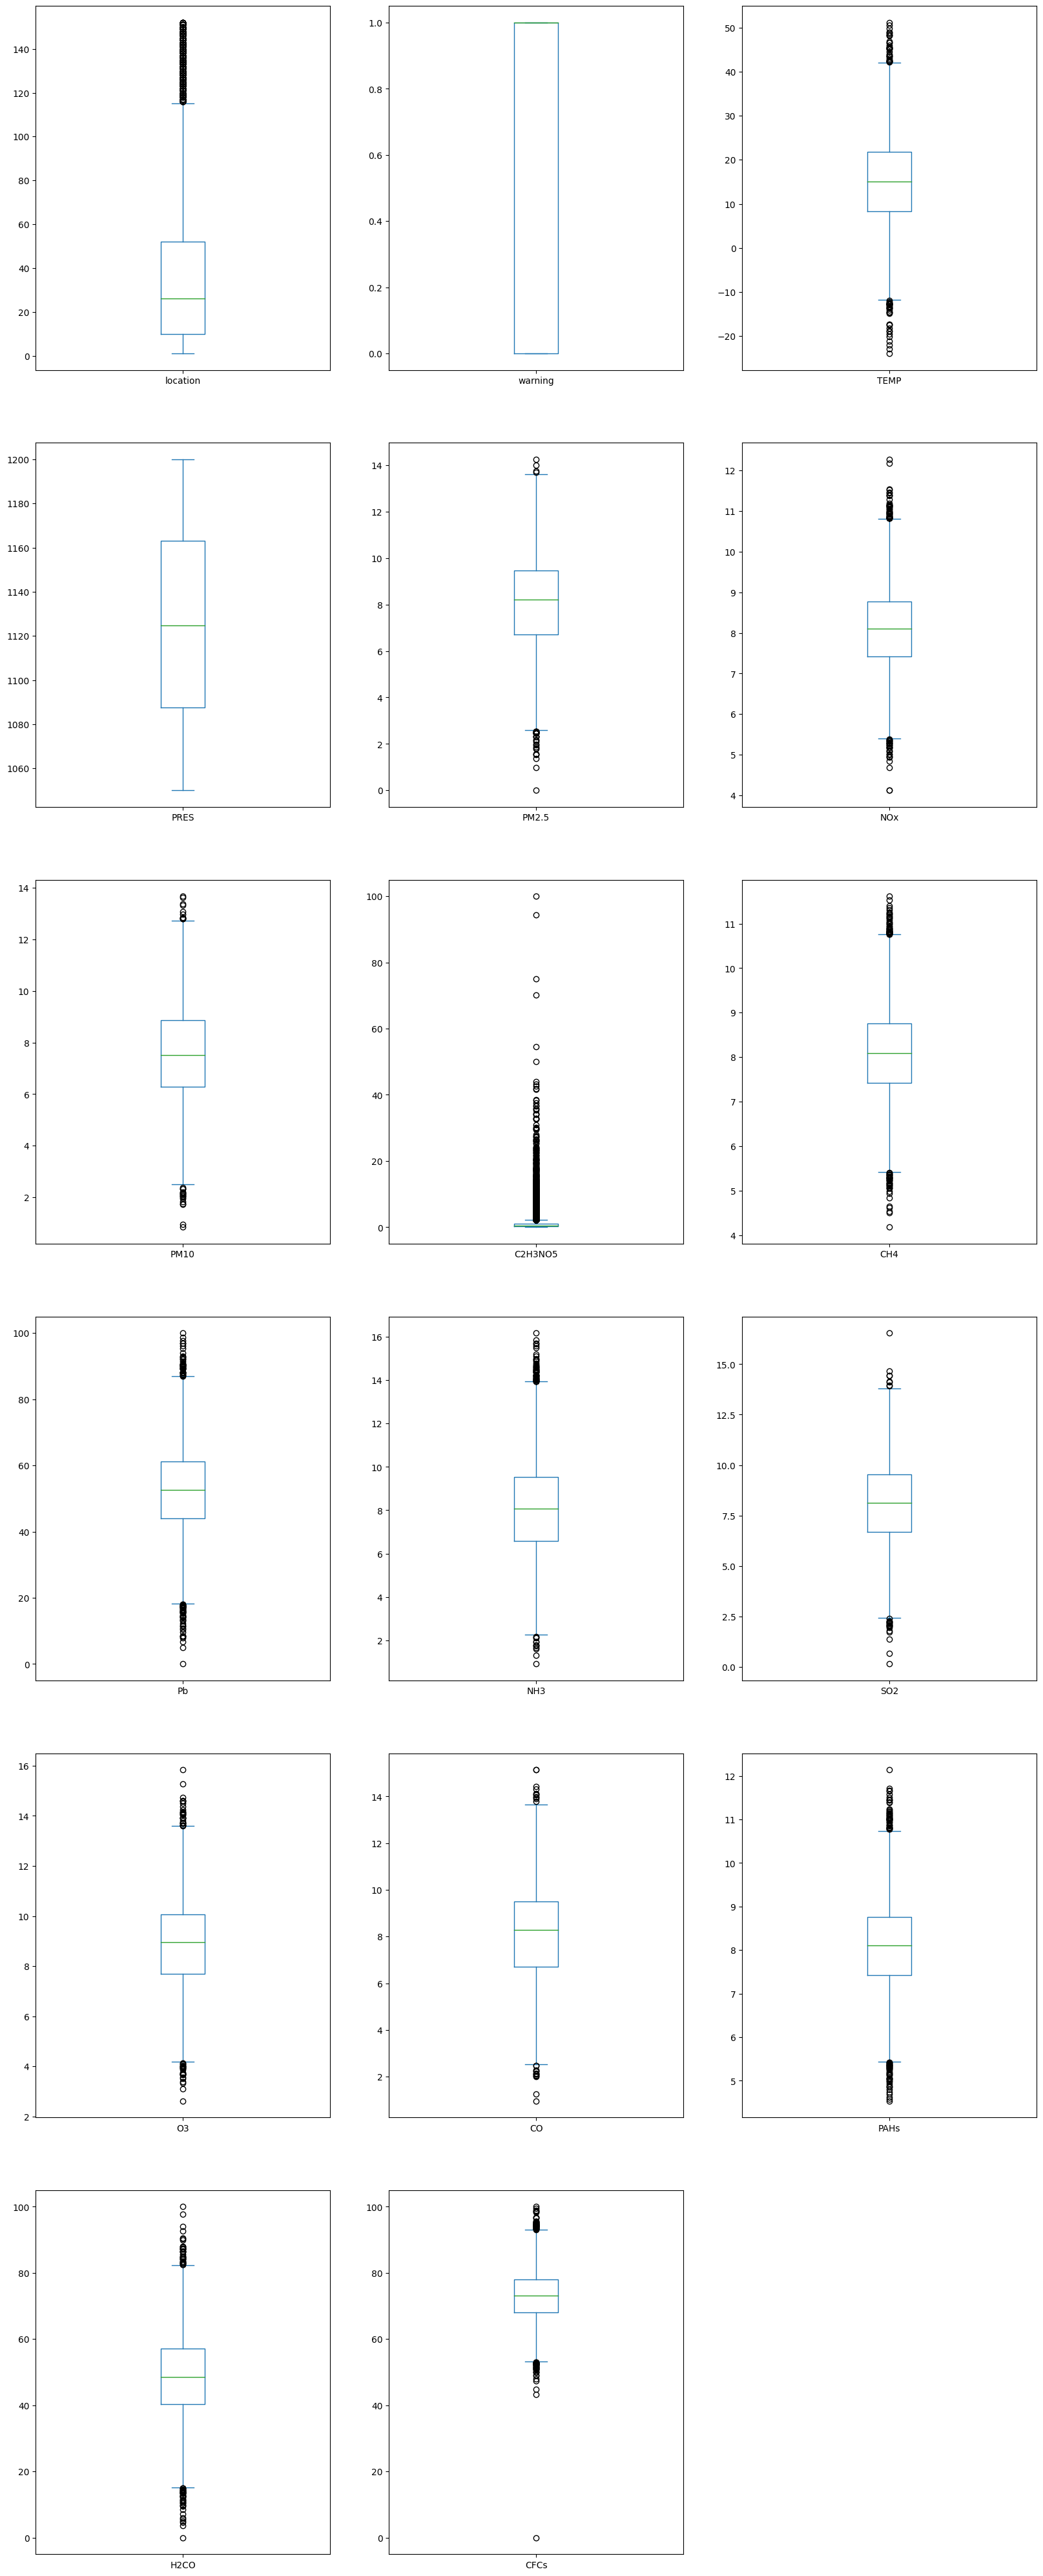

In [14]:
df_ml_na_knn.plot(kind='box', subplots=True, layout=(7, 3), sharex=False, sharey=False, figsize=(20, 60))


In [15]:
outliers_limit_low = 0
outliers_limit_up = 0
def identify_outliers(df):
    
    Qa = df.quantile(0.05)
    Qb = df.quantile(0.95)
    IQR = Qb - Qa
    
    global outliers_limit_low
    outliers_limit_low = (Qa - 1.5 * IQR)
    global outliers_limit_up 
    outliers_limit_up = (Qb + 1.5 * IQR)
    
    return ((df < outliers_limit_low) | (df > outliers_limit_up)).sum()

In [16]:
identify_outliers(df_ml_na_knn)

location      0
warning       0
TEMP          0
PRES          0
PM2.5         0
NOx           0
PM10          0
C2H3NO5     156
CH4           0
Pb            0
NH3           0
SO2           0
O3            0
CO            0
PAHs          0
H2CO          0
CFCs          1
dtype: int64

In [17]:
outliers_limit_low

location   -169.500000
warning      -1.500000
TEMP        -50.430883
PRES        854.703742
PM2.5        -4.489507
NOx           1.560324
PM10         -4.331160
C2H3NO5      -7.407493
CH4           1.444322
Pb          -31.439569
NH3          -5.613780
SO2          -4.931287
O3           -2.674604
CO           -4.283335
PAHs          1.526239
H2CO        -34.562272
CFCs         24.611047
dtype: float64

In [18]:
outliers_limit_up

location     290.500000
warning        2.500000
TEMP          80.218306
PRES        1395.596283
PM2.5         20.336645
NOx           14.634593
PM10          19.669400
C2H3NO5       12.691027
CH4           14.707791
Pb           136.591623
NH3           21.987593
SO2           20.960774
O3            20.094848
CO            20.022425
PAHs          14.676527
H2CO         131.515877
CFCs         121.715562
dtype: float64

In [19]:
def replace_outliers(df_original):
    df = df_original.copy()
    
    for col in df.columns:

        low = outliers_limit_low[col]
        up = outliers_limit_up[col]
        df[col] = np.where(df[col] < low, low, df[col])
        df[col] = np.where(df[col] > up, up, df[col])
        
    return df

In [20]:
df_ml_na_knn_notOutliers = replace_outliers(df_ml_na_knn)

In [21]:
identify_outliers(df_ml_na_knn_notOutliers)

location    0
warning     0
TEMP        0
PRES        0
PM2.5       0
NOx         0
PM10        0
C2H3NO5     0
CH4         0
Pb          0
NH3         0
SO2         0
O3          0
CO          0
PAHs        0
H2CO        0
CFCs        0
dtype: int64

## 2.2 Realizácia predspracovania dát (5b).
* Transformované dáta pre strojové učenie si rozdeľuje na trénovaciu a testovaciu množinu podľa vami preddefinovaným pomerom. Naďalej pracujte len s trénovacím datasetom.
* Transformujte atribútov dát pre strojové učenie podľa dostupných techník (minimálne 2 techniky) ako scaling, transformers a ďalšie.
* Zdôvodnite Vašu voľby/rozhodnutie pre realizáciu (t.j. zdokumentovanie)


In [22]:
df = df_ml_na_knn_notOutliers.copy()

### Transforovanie a škálovanie dát

/var/folders/tj/_nl_hwzj02n8b9pt35wr92zw0000gn/T/ipykernel_26603/2370537954.py:28: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(16, 2, num+1)
/var/folders/tj/_nl_hwzj02n8b9pt35wr92zw0000gn/T/ipykernel_26603/2370537954.py:28: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(16, 2, num+1)
/var/folders/tj/_nl_hwzj02n8b9pt35wr92zw0000gn/T/ipykernel_26603/2370537954.py:28: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(16, 2, num+1)
/var/folders/tj/_nl_hwzj02n8b9pt35wr92zw0000gn/T/ipykernel_26603/2370537954.py:28: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is de

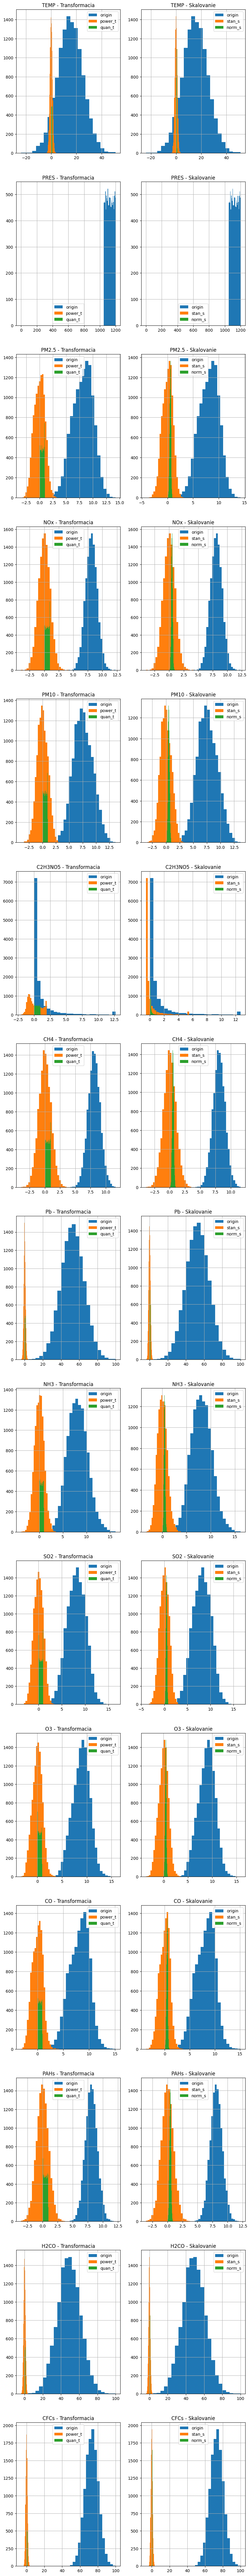

In [23]:
power = PowerTransformer(method='yeo-johnson', standardize=True)
quan = QuantileTransformer(n_quantiles=20, random_state=0)
stan_s = StandardScaler()
norm_s = MinMaxScaler()

m_col = [
    'TEMP', 'TEMP', 
    'PRES', 'PRES',
    'PM2.5', 'PM2.5', 
    'NOx', 'NOx', 
    'PM10','PM10', 
    'C2H3NO5', 'C2H3NO5', 
    'CH4', 'CH4',
    'Pb', 'Pb',          
    'NH3', 'NH3', 
    'SO2', 'SO2',
    'O3', 'O3',
    'CO', 'CO',
    'PAHs', 'PAHs', 
    'H2CO', 'H2CO',
    'CFCs', 'CFCs'
]

fig, axs = plt.subplots(2, 2, figsize=(10,120))

for num, col_name in enumerate(m_col):
    
    plt.subplot(16, 2, num+1)
    plt.hist(df[col_name], bins=25)
    
    if num % 2 == 0:
        plt.title(col_name + ' - Transformacia')
        pow_trans = power.fit_transform(df[[col_name]])
        plt.hist(pow_trans, bins=25)
        q_trans = quan.fit_transform(df[[col_name]])

        plt.hist(q_trans, bins=25)
        plt.grid()
        plt.legend(['origin', 'power_t', 'quan_t'])

    
    else:
        plt.title(col_name + ' - Skalovanie')
        s_scaled = stan_s.fit_transform(df[[col_name]])
        plt.hist(s_scaled, bins=25)
        n_scaled = norm_s.fit_transform(df[[col_name]])

        plt.hist(n_scaled, bins=25)
        plt.grid()
        plt.legend(['origin', 'stan_s', 'norm_s'])


In [24]:
# @TODO napísať vyhodnotenie pre tieto obrázky

### Rozdelenie dát 

Dataset rozdelíme v pomere 1/3 pre testovaciu množinu a 2/3 pre trénovaciu množinu 
pre indikátor (y) a pre všetky ostatné atribúty (X).

In [25]:
X_train, X_test, y_train, y_test = train_test_split(df.drop(['warning'], axis=1), df['warning'], test_size=0.33)

yeo-johnson sme vybrali preto lebo Box-cox nepodporuje transformáciu záporných hodnôt

### Zhodnotenie

@TODO

## Výber atribútov pre strojové učenie (5b)
* Zistite ktoré atribúty (features) vo vašich dátach pre strojové učenie sú informatívne k atribútu “warning”. Zoradíte tie atribúty v poradí podľa dôležitosti. 
* Zdôvodnite Vašu voľby/rozhodnutie pre realizáciu (t.j. zdokumentovanie)

### Variance Threshold

In [26]:
X = X_train.copy()
y = y_train.copy()
print(X.columns)
sel = VarianceThreshold(threshold=(.8 * (1 - .8)))
colsVT = sel.fit_transform(X)

Index(['location', 'TEMP', 'PRES', 'PM2.5', 'NOx', 'PM10', 'C2H3NO5', 'CH4',
       'Pb', 'NH3', 'SO2', 'O3', 'CO', 'PAHs', 'H2CO', 'CFCs'],
      dtype='object')


In [27]:
print('Pôvodný počet stĺpcov: ', X.shape[1])
if (X.shape[1] == colsVT[0].size):
    print('Všetky dáta sú užitočné')
elif (colsVT[0].size < X.shape[1]):
    print('Máme aj neužitočné dáta')

Pôvodný počet stĺpcov:  16
Všetky dáta sú užitočné


In [28]:
# -------------------

In [29]:
def orderColumns(X, y, selectionType, selectionTypeCategory):
    
    if (selectionTypeCategory == 'SelectKBest'):
        selector = SelectKBest(selectionType, k ='all')
    
    elif (selectionTypeCategory == 'SelectPercentile'):
        selector = SelectPercentile(selectionType, percentile=100)
    
    X_selected = selector.fit_transform(X, y)
    
    scores = selector.scores_
    
    col_names = X.columns[selector.get_support()]
    
    indices = []
    
    for _, x in sorted(zip(scores, col_names), reverse=True):
        indices.append(x)
    
    
    return indices

In [30]:
list_of_list = []

### SelectKBest

In [31]:
orders_funcs_list = [mutual_info_regression, f_regression]

In [32]:
for i in orders_funcs_list:
    temp = orderColumns(X, y, i, 'SelectKBest')
    list_of_list.append(temp)
    print(temp)

['O3', 'PM10', 'C2H3NO5', 'NH3', 'PM2.5', 'SO2', 'CO', 'H2CO', 'Pb', 'CH4', 'location', 'TEMP', 'PRES', 'PAHs', 'NOx', 'CFCs']
['O3', 'PM10', 'C2H3NO5', 'CFCs', 'H2CO', 'CH4', 'Pb', 'PAHs', 'SO2', 'TEMP', 'NOx', 'NH3', 'PRES', 'CO', 'PM2.5', 'location']


### SelectPercentile

In [33]:
orders_funcs_list = [f_classif, f_regression]

In [34]:
for i in orders_funcs_list:
    temp = orderColumns(X, y, i, 'SelectPercentile')
    list_of_list.append(temp)
    print(temp)

['O3', 'PM10', 'C2H3NO5', 'CFCs', 'CO', 'H2CO', 'NOx', 'SO2', 'PM2.5', 'CH4', 'PAHs', 'Pb', 'TEMP', 'NH3', 'location', 'PRES']
['O3', 'PM10', 'C2H3NO5', 'CFCs', 'H2CO', 'CH4', 'Pb', 'PAHs', 'SO2', 'TEMP', 'NOx', 'NH3', 'PRES', 'CO', 'PM2.5', 'location']


### Záver výberov

In [35]:
def orderLists(X, list_of_list):
    
    x_columns = X.columns
    x_weights = []
    
    for i in range(len(x_columns)):
        x_weights.append(i)
    
    for lst in list_of_list:
        for i in range(len(x_columns)):
            x_weights[i] += lst.index(x_columns[i])  
            
    map_of_cols = []
    for _, q in sorted(zip(x_weights, x_columns)):
        map_of_cols.append(q)
    
    return map_of_cols 

In [36]:
orderLists(X, list_of_list)

['PM10',
 'O3',
 'C2H3NO5',
 'H2CO',
 'CH4',
 'SO2',
 'CFCs',
 'Pb',
 'TEMP',
 'PM2.5',
 'NOx',
 'NH3',
 'CO',
 'PAHs',
 'PRES',
 'location']

#### Záver výberu atribútov pre strojové učenie

text

## Replikovateľnosť predspracovania (5b)
* Upravte váš kód realizujúci predspracovanie trénovacej množiny tak, aby ho bolo možné bez ďalších úprav znovupoužiť na predspracovanie testovacej množiny (pomocou funkcie/í)
* Očakáva sa aj využitie možnosti sklearn.pipeline

### Code improvements

In [37]:
class HandleNaNs(TransformerMixin):
    
    def __init__(self, strategy):
        self.strategy = strategy
    
    def replaceNaN(self, df):
        na_cols = df.columns[df.isnull().any()].tolist()

        if self.strategy == 'kNN':
            imp_strategy = KNNImputer(n_neighbors=5, weights='uniform', metric='nan_euclidean')

        elif self.strategy == 'mean' or self.strategy == 'median':    
            imp_strategy = SimpleImputer(missing_values=np.nan, strategy=self.strategy)

        elif self.strategy == 'drop_na':
            df = df.dropna()
            
        else:
            raise Exception("Unknown method")

        if self.strategy != 'drop_na':
            for col in na_cols:
                df[col] = imp_strategy.fit_transform(df[[col]])

        print(df.isnull().sum())

        # fig, ax = plt.subplots(figsize=(16,8))
        # corr_diff = df.corr() - df_original.corr()
        # sns.heatmap(corr_diff[abs(corr_diff) > 0.000099], ax=ax, annot=True, fmt=".4f")

        return df
    
    def fit(self, X):
        return self
    
    def transform(self, X):
        return self.replaceNaN(X)

In [38]:
class HandleLocation(TransformerMixin):

    def encodeLocation(self, df):
        # prekodovanie textu locacie n číslo 
        ce_ordinal = ce.OrdinalEncoder(cols=['location'])
        return ce_ordinal.fit_transform(df)
        
    def fit(self, X):
        return self
    
    def transform(self, X):
        return self.encodeLocation(X)

In [39]:
class HandleOutliers(TransformerMixin):
    
    def __init__(self):
        pass
    
    def replaceOutliers(self, df):
    
        for col in df.columns:

            low = outliers_limit_low[col]
            up = outliers_limit_up[col]
            df[col] = np.where(df[col] < low, low, df[col])
            df[col] = np.where(df[col] > up, up, df[col])

        return df
         
    def fit(self, X):
        return self
    
    def transform(self, X):
        return self.replaceOutliers(X)

In [40]:
class HandleTransformations(TransformerMixin):

    def __init__(self, method):
        self.method = method
        
    def transformPower(self, df):
        power = PowerTransformer(method='yeo-johnson', standardize=True)
        return pd.DataFrame(power.fit_transform(df), columns = df.columns)

    
    def transormQuan(self, df):
        quan = QuantileTransformer(n_quantiles=10, random_state=0)
        return pd.DataFrame(quan.fit_transform(df), columns = df.columns)
    
    def scaleMM(self, df):
        norm_s = MinMaxScaler()
        return pd.DataFrame(norm_s.fit_transform(df), columns = df.columns)
        
    def scaleS(self, merged):
        stan_s = StandardScaler()
        return pd.DataFrame(stan_s.fit_transform(df), columns = df.columns)
    
    def fit(self, X):
        return self
    
    def transform(self, X):
        if self.method == 'power':
            return self.transformPower(X)
        elif self.method == 'quan':
            return self.transormQuan(X)
        elif self.method == 'minmax':
            return self.scaleMM(X)
        elif self.method == 'standard':
            return self.scaleS(X)
        else:
            raise Exception("Unknown method")

In [41]:
class HandleSelection(TransformerMixin):
    
    def __init__(self, list_attributes):
        self.list_attributes = list_attributes
        
    def fit(self, X):
        return self
    
    def transform(self, X):
            return X[self.list_attributes]

### Pipeline

In [42]:
def pipelineGenerator(
    nan_strategy='kNN', # 'drop_na', 'mean', 'median', 'kNN'
    tranformation_method='standard', # 'power', 'quan', 'minmax', 'standard' 
):
    
    pipeline =  Pipeline([
        ('handleNaNs', HandleNaNs(nan_strategy)), 
        
        ('handleLocation', HandleLocation()),
        
        ('handleOutliers', HandleOutliers()),
        
        ('handleTransformations', HandleTransformations(tranformation_method)),
        
        # ('handleSelection', HandleSelection())
    ])
    return pipeline

In [43]:
pipeline1 = pipelineGenerator()
transformed_data1 = pipeline1.fit_transform(df_not_changed)

location    0
warning     0
TEMP        0
PRES        0
PM2.5       0
NOx         0
PM10        0
C2H3NO5     0
CH4         0
Pb          0
NH3         0
SO2         0
O3          0
CO          0
PAHs        0
H2CO        0
CFCs        0
dtype: int64


In [44]:
transformed_data1

,location,warning,TEMP,PRES,PM2.5,NOx,PM10,C2H3NO5,CH4,Pb,NH3,SO2,O3,CO,PAHs,H2CO,CFCs
0,-1.047662,-1.213433,0.505995,0.324007,0.209579,1.121624,0.986871,0.177247,-0.236368,5.440759e-01,1.103815,-1.147903,-0.629654,0.837800,0.527468,-0.078940,0.236275
1,-1.047662,0.827435,0.657408,-0.227283,-0.366558,1.576340,0.337717,-0.238885,0.395876,1.159410e-01,0.722450,-0.060803,0.500266,-1.186366,0.189064,1.300350,-1.313503
2,-1.047662,0.827435,-1.201279,-0.899333,0.906870,1.570276,-0.769593,-0.431944,0.410710,-4.097348e-01,-0.807381,-0.981103,0.503348,-0.378975,-2.121715,-0.438624,-0.204308
3,-1.047662,0.827435,-0.499952,0.989725,0.359058,2.187585,-0.261126,-0.463008,-0.730274,-3.179354e-01,0.009598,-0.678087,0.446766,-1.679538,0.670014,-0.395282,-1.148582
4,-1.047662,0.827435,0.992181,-1.453846,-0.679333,1.867175,0.423376,-0.184090,-1.102101,2.790004e-02,0.366229,0.581854,-0.264184,1.429574,-0.211089,-0.656109,-0.360464
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11934,-0.794865,0.827435,-1.991721,0.117236,1.021266,-0.251030,-2.712732,-0.464253,-0.151749,-7.969786e-01,-0.746818,-0.533861,-2.601147,0.873613,-0.244639,-1.315295,1.151993
11935,-0.794865,-1.213433,-0.775604,1.539290,0.760322,1.527609,0.716296,-0.094304,-0.294810,-1.004370e+00,-0.538778,1.254361,-0.804167,2.125972,0.712592,1.972248,-1.256945
11936,-0.794865,0.827435,0.142736,-1.023656,0.474021,0.833876,0.893144,0.146383,0.216537,1.242773e-01,-0.108628,-0.211664,2.272797,-0.571773,0.196374,0.982662,0.530688
11937,-0.794865,-1.213433,-0.898905,-1.065738,1.617114,-1.232571,-0.201731,-0.393674,0.100806,-5.560213e-16,-0.124791,0.461577,-0.406507,1.699837,0.304858,0.417492,1.930932
